# *Library and file dependancies*

In [57]:
# Single cell 
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
# Output control
import warnings
warnings.filterwarnings("ignore")

*Single cell utility functions*

In [58]:
from utils.plotting import *
from utils.optimization import *
from utils.stats import *

*data file path*

In [59]:
filepath = 'datasets/'

# 1. **Preprocessing**

## **Data formatting** 

The original counts matrix is in txt format, where the columns are cells and the rows are genes. For this reason we load the dataset into a pandas dataframe and:
1. Remove the gene_id and gene_type columns
2. Set the gene name column as the index
3. Transpose the Dataframe

Finally we can load the Dataframe into an AnnData object, readable by scanpy. 

In [60]:
# Pass the txt file into a csv via pandas with tab delimeter
df = pd.read_csv(filepath+"GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt", delimiter="\t")
df.drop(['gene_id','gene_type'], axis = 1, inplace = True)
df.set_index('gene_name', drop=True, inplace=True)
df = df.rename_axis(None)
df  = df.T 
adata = sc.AnnData(df.values)
adata.var_names = df.columns  # Assign column names as feature (gene) names
adata.obs_names = df.index  # Assign row names as observation names (cell or sample names)
adata.var_names_make_unique() # In case of repeatring genes, make the unique
print(adata)
print("\n---------------------\n")
print(adata.obs_names)

AnnData object with n_obs × n_vars = 563 × 57915

---------------------

Index(['BC01_Pooled', 'BC01_Tumor', 'BC02_Pooled', 'BC03_Pooled',
       'BC03LN_Pooled', 'BC04_Pooled', 'BC05_Pooled', 'BC06_Pooled',
       'BC07_Tumor', 'BC07LN_Pooled',
       ...
       'BC11_04', 'BC11_07', 'BC11_28', 'BC11_43', 'BC11_56', 'BC11_69',
       'BC11_70', 'BC11_78', 'BC11_81', 'BC11_88'],
      dtype='object', length=563)


We have a counts matrix with 563 observations and 57915 genes. As you can see in the adata object observation we also have pooled tumour samples. Thus we will seperate the information into two adata objects:
- One for pooled cell counts `padata` 
- One for cell counts `cadata`

In [61]:
# Cell adata 
cadata = adata[14:]
print(f"Cell adata obvervations: {cadata.obs_names}\n")
padata = adata[:14]
padata = padata[padata.obs_names != 'BC01_Tumor']
print(f"Pool cell adata observations: {padata.obs_names}\n")

Cell adata obvervations: Index(['BC01_02', 'BC01_03', 'BC01_04', 'BC01_05', 'BC01_06', 'BC01_08',
       'BC01_10', 'BC01_11', 'BC01_12', 'BC01_24',
       ...
       'BC11_04', 'BC11_07', 'BC11_28', 'BC11_43', 'BC11_56', 'BC11_69',
       'BC11_70', 'BC11_78', 'BC11_81', 'BC11_88'],
      dtype='object', length=549)

Pool cell adata observations: Index(['BC01_Pooled', 'BC02_Pooled', 'BC03_Pooled', 'BC03LN_Pooled',
       'BC04_Pooled', 'BC05_Pooled', 'BC06_Pooled', 'BC07_Tumor',
       'BC07LN_Pooled', 'BC08_Pooled', 'BC09_Pooled', 'BC10_Pooled',
       'BC11_Pooled'],
      dtype='object')



To assign each cell population to a tumor group, follow these steps:
The cell names follow the pattern "BC" + PREFIX + "02-11" + PATIENT + "_" + "cell number". Extract the patient tumor identifier by removing the specific cell number. For example, convert "BC02_02" to "BC02".
The researchers have removed the cells of patient "BC05" due to herceptin treatment, but we choose to keep them as we believe they can provide interesting results.We Annotate these cells with an added "herceptin" marker.

In [62]:
tumor_groups_c = [obs_name if "Pooled" in obs_name else obs_name.split("_")[0] for obs_name in cadata.obs_names]
tumor_groups_p = [obs_name if "Pooled" in obs_name else obs_name.split("_")[0] for obs_name in padata.obs_names]
cadata.obs['tumor_groups'] = tumor_groups_c
padata.obs['tumor_groups'] = tumor_groups_p
# For example the first gorup of cells should belong to the tumor of patient one 
cadata.obs['tumor_groups'].head()
tumor_groups = cadata.obs['tumor_groups'].copy()
for i,patient in enumerate(tumor_groups):
  if ((patient[3] == '1') or (patient[3] == '2')) and  patient[2] == '0':
    tumor_groups[i] += " Luminal-A"
  elif (patient[3] == '3'):
    tumor_groups[i] += " Luminal-B"
  elif (patient[3] == '4') or (patient[3] == '6'):
    tumor_groups[i] += " HER2"
  elif (patient[3] == '5'):
    tumor_groups[i] += " HER2\n(Herceptin)"
  else:
    tumor_groups[i] += " TNBC"
cadata.obs['tumor_groups'] = tumor_groups
cadata.obs['tumor_groups'].head() 

BC01_02    BC01 Luminal-A
BC01_03    BC01 Luminal-A
BC01_04    BC01 Luminal-A
BC01_05    BC01 Luminal-A
BC01_06    BC01 Luminal-A
Name: tumor_groups, dtype: object

## **Quality Control**

For quality control we utilize our own pipeline following [single cell best practises](https://www.sc-best-practices.org/preamble.html), we end up with 518 cells rather than 515 of the Authors.

Before we begin we simply remove genes that have 0 expression across all cells since they can affect heavily the QC process

In [63]:
mask = cadata.X.sum(axis = 0) == 0
cadata = cadata[:,~mask]
padata = padata[:,~mask]
cadata

View of AnnData object with n_obs × n_vars = 549 × 36123
    obs: 'tumor_groups'

## **Cell fileting**

As you can see this removed 21.792 genes that were not expressed in any of the cells

We continue with the QC:

To maintain quality control, we follow the best practices by removing cells from our analysis that show certain characteristics. These characteristics include having a small number of detected genes, low count depth, and a high proportion of mitochondrial counts. These traits may suggest that the cell membrane is compromised or that the cell is dead. Since these cells are not the main focus of our analysis and can affect the accuracy of our subsequent analysis, we remove them from our dataset using the three covariates.

  - The number of counts per cell (count depth)

  - The number of genes per cell

  - The fraction of counts from mitochondrial genes per cell <--- However in the context of breast cancer, since cancer cells may have altered mitchondrial pathways, we wont remove cells based on the last covariate

Below we annotate mitochondrial genes:

In [64]:
# mitochondrial genes
cadata.var["mt"] = cadata.var_names.str.startswith("MT-")

Before proceeding with cell & gene filtering we annotate quality control metrics to the counts matrix via scanpy's `calculate_qc_metrics` for the `cadata` counts matrix for the top 20% genes.

In [65]:
sc.pp.calculate_qc_metrics(cadata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
sc.pp.calculate_qc_metrics(padata, inplace=True, log1p=True)
cadata

AnnData object with n_obs × n_vars = 549 × 36123
    obs: 'tumor_groups', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

- "log1p total counts" refers to the log transformed overall count of all gene expression in a cell.
- The "log1p n genes by counts" value signifies the log transformed number of genes expressed in each cell.
- The "pct_counts_in_top_20_genes" value show the percentage of the total expression in each cell the 20 most expressed genes have.

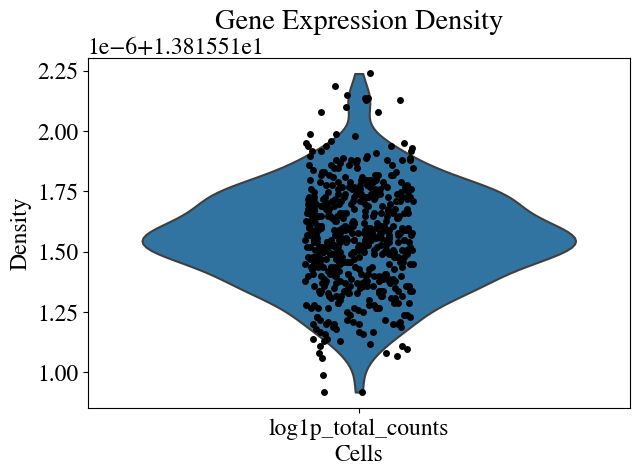

In [66]:
sc.pl.violin(cadata, "log1p_total_counts", show =False, size = 5)
plt.title("Gene Expression Density")
plt.xlabel("Cells")
plt.ylabel("Density")
plt.show()

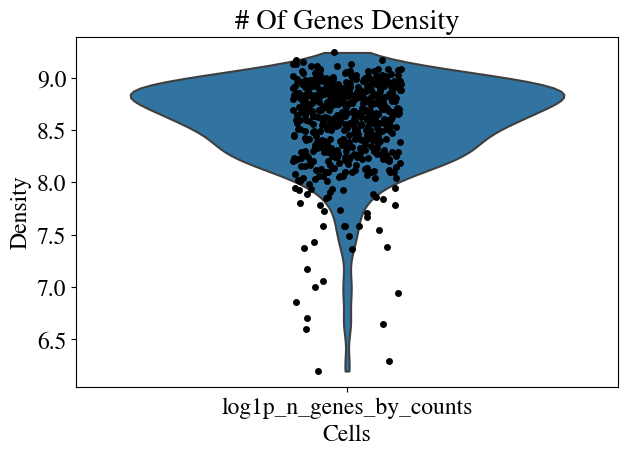

In [67]:
sc.pl.violin(cadata, "log1p_n_genes_by_counts", show =False, size = 5)
plt.title("# Of Genes Density")
plt.xlabel("Cells")
plt.ylabel("Density")
plt.show()

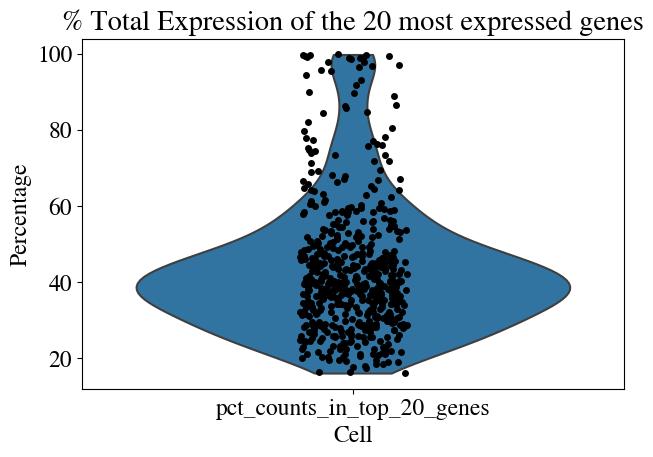

In [68]:
sc.pl.violin(cadata, "pct_counts_in_top_20_genes", show =False, size = 5)
plt.title("% Total Expression of the 20 most expressed genes")
plt.xlabel("Cell")
plt.ylabel("Percentage")
plt.show()

Based on the above, we remove cells that are located 5 absolute deviations from the median in any of the above distributions.
$$ MAD = median(|X_i - median(X))$$

In [69]:
cadata.obs["outlier"] = (
    is_outlier(cadata, "log1p_total_counts", 5)
    | is_outlier(cadata, "log1p_n_genes_by_counts", 5)
    | is_outlier(cadata, "pct_counts_in_top_20_genes", 5)
)
cadata.obs.outlier.value_counts()

False    518
True      31
Name: outlier, dtype: int64

We obtained a count of 518 cells, which is very close to the 515 cells that the authors retained in their study.

# **Gene filtering**

For gene filtering we attempt to follow the researchers' workflow and:
1. Set to 0 genes with counts < 1.
2. Log transform the genes after adding a value of 1 using a base of 2

In [70]:
cadata = cadata[~cadata.obs.outlier]
cadata.X[cadata.X < 1] = 0
sc.pp.normalize_total(cadata,inplace=True,  exclude_highly_expressed = True )
sc.pp.log1p(cadata,base=2)
sc.pp.normalize_total(padata,inplace=True, exclude_highly_expressed = True )
sc.pp.log1p(padata,base=2)

3. Remove genes that are expressed in less than 10% of all tumour groups.

Despite numerous attempts and various interpretations, the third step remained ambiguous, and we were unable to replicate the results achieved by the researchers. Nevertheless, we present below our best two approaches that yielded the most promising results.

## **Gene Filtering method 1: Remove all genes that are expressed in less than 10% of the total number of tumour groups**

In [71]:
cadata1 = cadata.copy()
padata1 = padata.copy()

Now we can filter out all the genes expressed in 10% of all tumour groups.

In [73]:
df_expression = pd.DataFrame(data=cadata1.X, columns=cadata1.var_names)
df_expression['tumor_groups'] = cadata1.obs['tumor_groups'].values

# Group by tumor groups and sum the expression values for cells in the group
group1 = df_expression.groupby("tumor_groups").sum() 

In [74]:
df_expression = pd.DataFrame(data=cadata1.X, columns=cadata1.var_names)
df_expression['tumor_groups'] = cadata1.obs['tumor_groups'].values

# Group by tumor groups and sum the expression values for cells in the group
group = df_expression.groupby("tumor_groups").sum() 
# Make expression binary
group[group > 0] = 1
mask = group.sum(axis = 0) < 0.1 * group.shape[0] 
cadata1 = cadata1[:,~mask]
padata1 = padata1[:,~mask]
cadata

AnnData object with n_obs × n_vars = 518 × 36123
    obs: 'tumor_groups', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [75]:
# We remove the BC01 tumour since that information is included in BC01_pooled
padata1 = padata1[~(padata1.obs_names == 'BC01_Tumor'), :] 

With this method we obtained $\approx$ 27,000 genes out of the $\approx$ 57,000 total, which is higher than the $\approx$ 17,000 genes reported by the authors

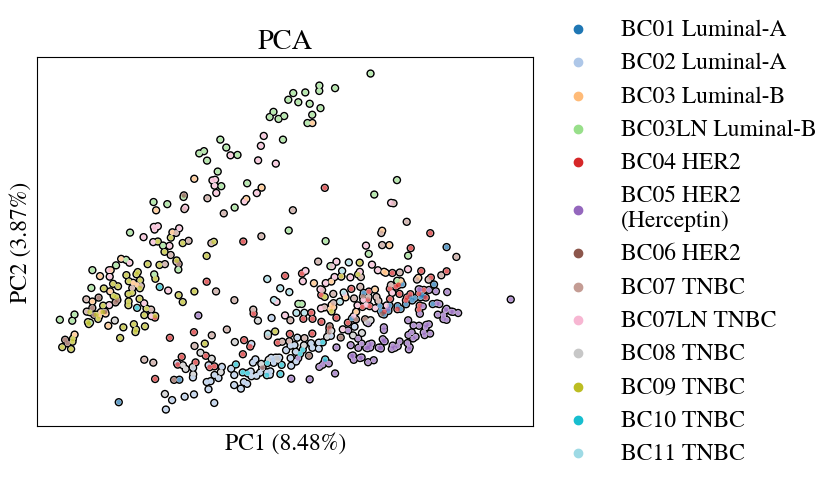

In [76]:
sc.pp.pca(cadata1)
sc.pl.pca(cadata1, color = "tumor_groups",annotate_var_explained = True, title = "PCA",add_outline=True, size = 50,palette = "tab20")

## **Gene Filtering method 2: Removal of genes that are expressed in 10% of the cells of each tumour group for all tumour groups**

In [77]:
cadata2 = cadata.copy()
padata2 = padata.copy()

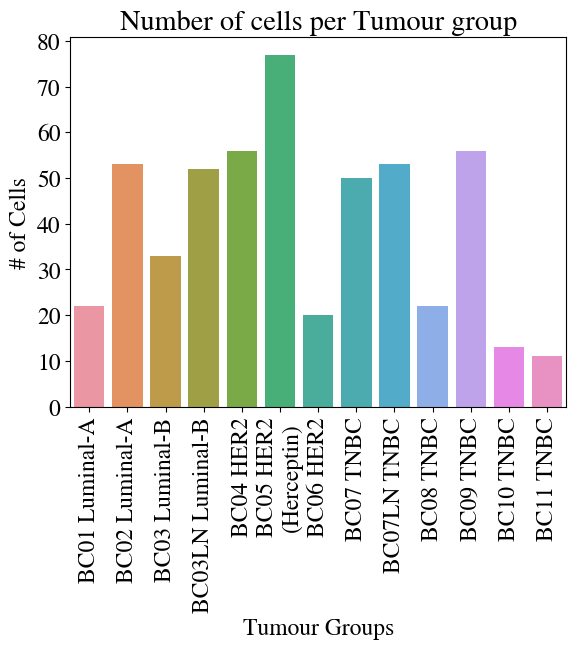

In [78]:
value_counts = cadata2.obs['tumor_groups'].value_counts()
sns.barplot(x = value_counts.index, y = value_counts.values)
plt.title("Number of cells per Tumour group")
plt.xticks(rotation = 90)
plt.yticks(np.arange(0,90,10))
plt.ylabel("# of Cells")
plt.xlabel("Tumour Groups")
plt.show()

To determine the fractions of cells expressing each gene relative to the tumor groups, we employ the `rank_genes_groups` function, setting the `pts` argument to True.

In [79]:
sc.tl.rank_genes_groups(cadata2, 'tumor_groups', method='wilcoxon',pts= True)
matrix = cadata2.uns['rank_genes_groups']['pts']

Below we present a heatmap illustration of this information.

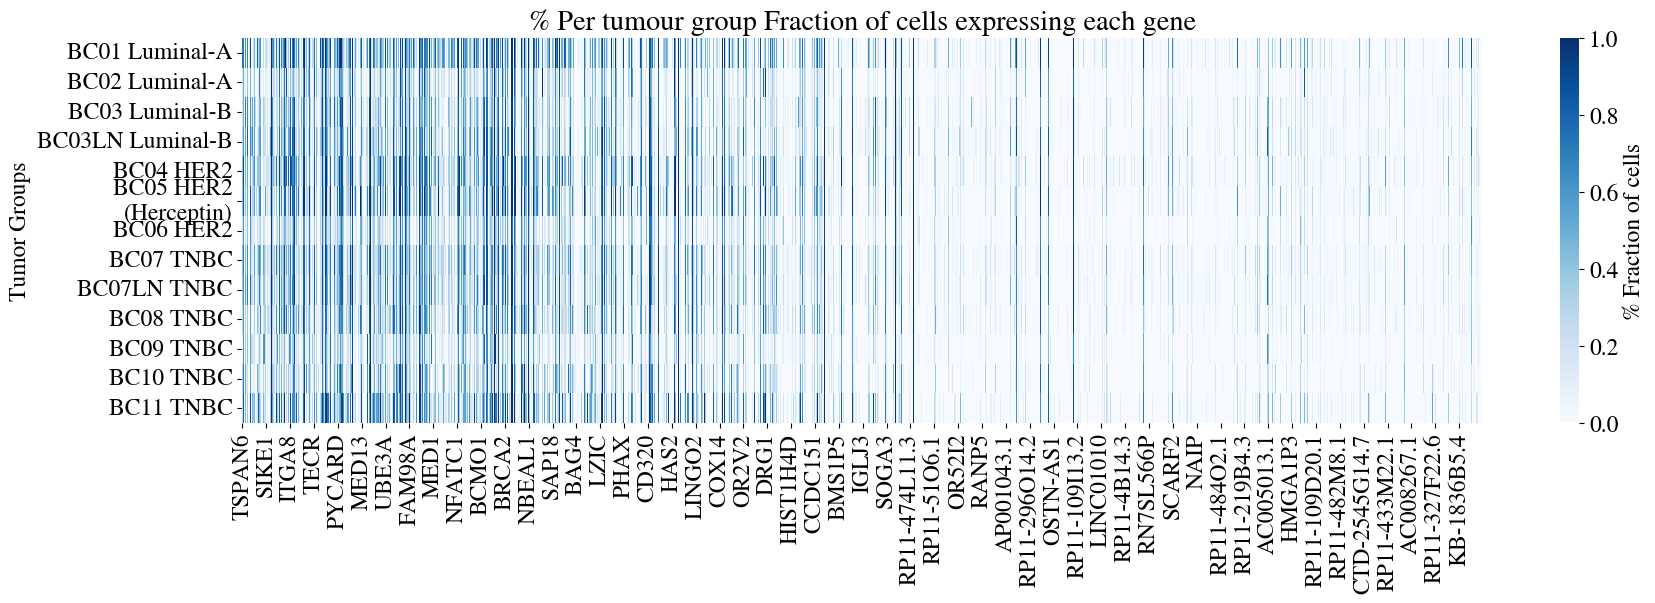

In [80]:
plt.figure(figsize=(20,5))
plt.title("% Per tumour group Fraction of cells expressing each gene")
sns.heatmap(matrix.T,cmap='Blues',cbar_kws={'label': '% Fraction of cells'})
plt.ylabel("Tumor Groups") 
plt.show()

We then create mask that captures all genes with tumour group cell fractional expression $10\%$

In [81]:
total_tumour_groups = 13
mask  = ((matrix < 0.1).sum(axis=1) == total_tumour_groups)
cadata2 = cadata2[:, ~mask]
padata2 = padata2[:,~mask]

We end up with 17851, much closer to the 17779 of the paper with this method.

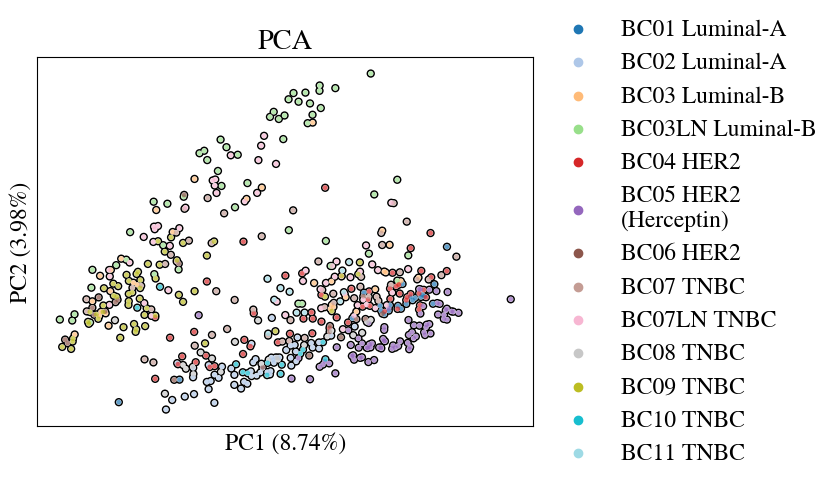

In [82]:
sc.pp.pca(cadata2)
sc.pl.pca(cadata2, color = "tumor_groups",annotate_var_explained = True, title = "PCA",add_outline=True, size = 50,palette = "tab20")

# Save the processed adata objects

Although the second approach resulted in a genes number similar to that of the authors, we encountered problems with a significant number of missing genes from the dataset during the Gene Set Variation Analysis in a later stage. Therefore, we have decided to retain the approximate 27,000 genes from the original gene filtering approach since their PCA representation yields similar results.

In [83]:
cadata1.write("datasets/processed_cellcounts.h5ad")
padata1.write("datasets/processed_pooledcounts.h5ad")